# Compare simulation and mean field for Potjans' model


In [16]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
plt.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

colors = style.colors

## Mean field model

In [17]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        if u < -4.0:
            return np.exp(x**2) * \
                np.exp(-u**2) / np.sqrt(np.pi) * (u**-2
                                                    - u**-4
                                                    + 7.0 * u**-6 / 4.0
                                                    - 9.0 * u**-8 / 2.0)
        else:
            return np.exp(x**2) * np.exp(u**2) * (1. + erf(u))**2

    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * v0**2 * dbl_integral * model.tau_m**2) # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [18]:
def plot_compare_sim_mf(data_sim, data_mf, ax):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=2, ms=20)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.4) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=2, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
    ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=2, ms=5) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

## With connection_rule = "fixed_total_number":

Use jacobian
Integration time: 0.24
CV calc time: 0.70


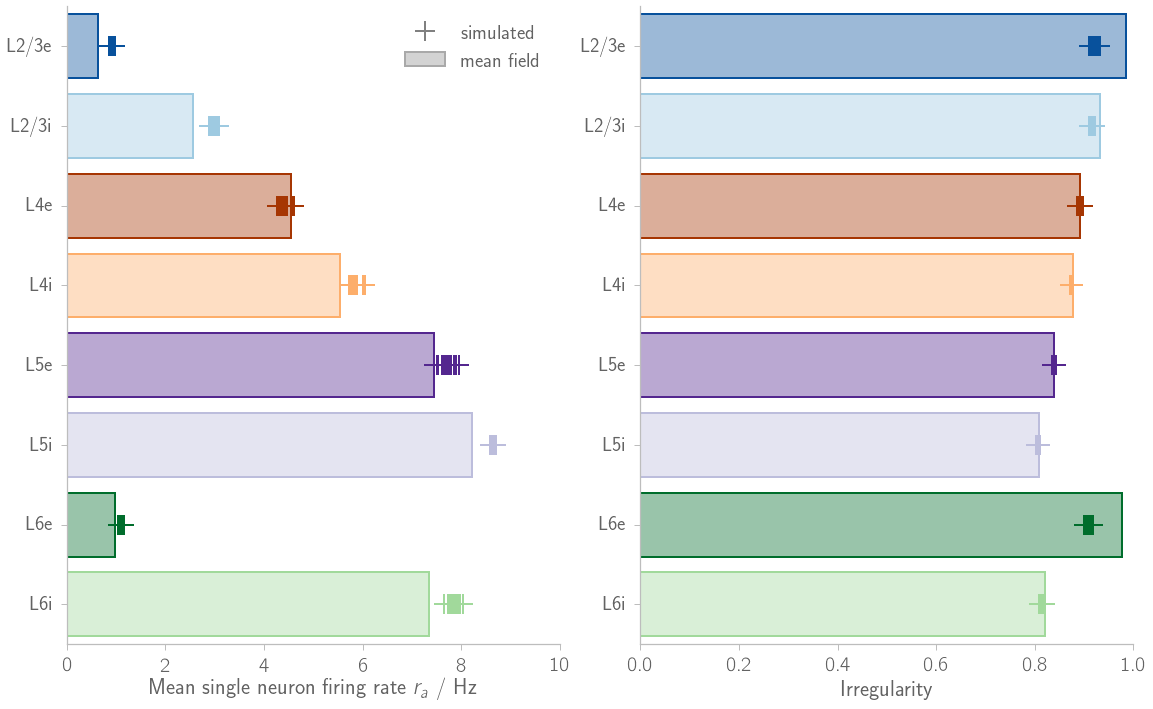

In [43]:
######################################################
# Mean field results
######################################################

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
jacobian=True
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model_micro, v_guess_0,
                          jacobian=jacobian,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model_micro)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA
sim_spec = "spon_act_statistic"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all  = np.zeros((n_sims, n_populations))
    cv_isi_mean_all = np.zeros((n_sims, n_populations))
    synchrony_all   = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        synchrony_all[j]    = res_grp["synchrony"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)



for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_total_number"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Print numerical results: Rates and CV of ISI (for latex)

In [42]:
# Firing rates
r_mf = rate_mf
r_sim = np.mean(rates_mean_all, axis=0)

# Absolute deviation for rates
drs = (r_mf - r_sim)
drstr = ""
for dr in drs:
    drstr += "& {0:5.2f} ".format(dr)
drstr += r"\tn[0.2cm]"
# Relative deviation for rates
rdrs = drs / r_sim
rdrstr = ""
for rdr in rdrs:
    rdrstr += "& {0:5.2f} ".format(rdr)
rdrstr += r"\tn[0.2cm]"
    
# String for Table    
tabstr  = r"$\Delta \nu_a$ / Hz"  + "\n    "
tabstr += drstr  + "\n"
tabstr += r"$\Delta \nu_a / \nu_{\text{sim}, a}$"  + "\n    "
tabstr += rdrstr 
print(tabstr)
mean_str_rate = "({0:4.2f} \\pm {1:4.2f}) Hz".format(np.mean(abs(drs)), np.std(abs(drs)))

# CV of ISI
r_mf = cv_isi_mf 
r_sim = np.mean(cv_isi_mean_all, axis=0)

# Absolute deviation for rates
drs = (r_mf - r_sim)
drstr = ""
for dr in drs:
    if dr < 0.001:
        drstr += "& %.e"%dr
        drstr = drstr[:-2] + drstr[-1]
    else:
        drstr += "& {0:7.3f} ".format(dr)
drstr += r"\tn[0.2cm]"
# Relative deviation for rates
rdrs = drs / r_sim
rdrstr = ""
for rdr in rdrs:
    if rdr < 0.001:
        rdrstr += "& %.e"%rdr
        rdrstr = rdrstr[:-2] + rdrstr[-1]
    else:
        rdrstr += "& {0:7.3f} ".format(rdr)
rdrstr += r"\tn[0.2cm]"
    
# String for Table    
tabstr  = r"$\Delta \text{CV}_a$"  + "\n    "
tabstr += drstr  + "\n"
tabstr += r"$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$"  + "\n    "
tabstr += rdrstr  + "\n"
print(tabstr)

mean_str = "({0:4.2f} \\pm {1:4.2f})".format(np.mean(abs(drs)), np.std(abs(drs)))
proz_str = "({0:d} \\pm {1:d})".format(int(np.mean(abs(drs)) / np.mean(r_sim) * 100), 
                                       int(np.std(abs(drs)) / np.mean(r_sim) * 100))



print(mean_str_rate)
print("\n")
print(mean_str)
print(proz_str)

$\Delta \nu_a$ / Hz
    & -0.28 & -0.44 &  0.15 & -0.30 & -0.26 & -0.43 & -0.12 & -0.51 \tn[0.2cm]
$\Delta \nu_a / \nu_{\text{sim}, a}$
    & -0.31 & -0.15 &  0.03 & -0.05 & -0.03 & -0.05 & -0.11 & -0.06 \tn[0.2cm]
$\Delta \text{CV}_a$
    &   0.063 &   0.016 & -4e-4&   0.002 & 6e-4&   0.002 &   0.067 &   0.007 \tn[0.2cm]
$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$
    &   0.069 &   0.017 & -5e-4&   0.002 & 7e-4&   0.002 &   0.073 &   0.009 \tn[0.2cm]

(0.31 \pm 0.13) Hz


(0.02 \pm 0.03)
(2 \pm 3)


In [44]:
rate_mf

array([ 0.63966743,  2.56414279,  4.54636958,  5.54078414,  7.43963759,
        8.2168913 ,  0.98173986,  7.33749468])

(array([ 4.22348797,  3.26064097,  4.47523741,  2.52197922,  7.20709458,
         1.54285795,  1.67353431,  1.27777212]),
 array([ 0.31494544,  1.19285976,  2.01312631,  2.40943276,  3.07564595,
         3.24592763,  0.47980267,  2.95740336]),
 array([ 13.41022116,   2.73346547,   2.22302863,   1.04671077,
          2.34327835,   0.47532112,   3.48796375,   0.43205879]))

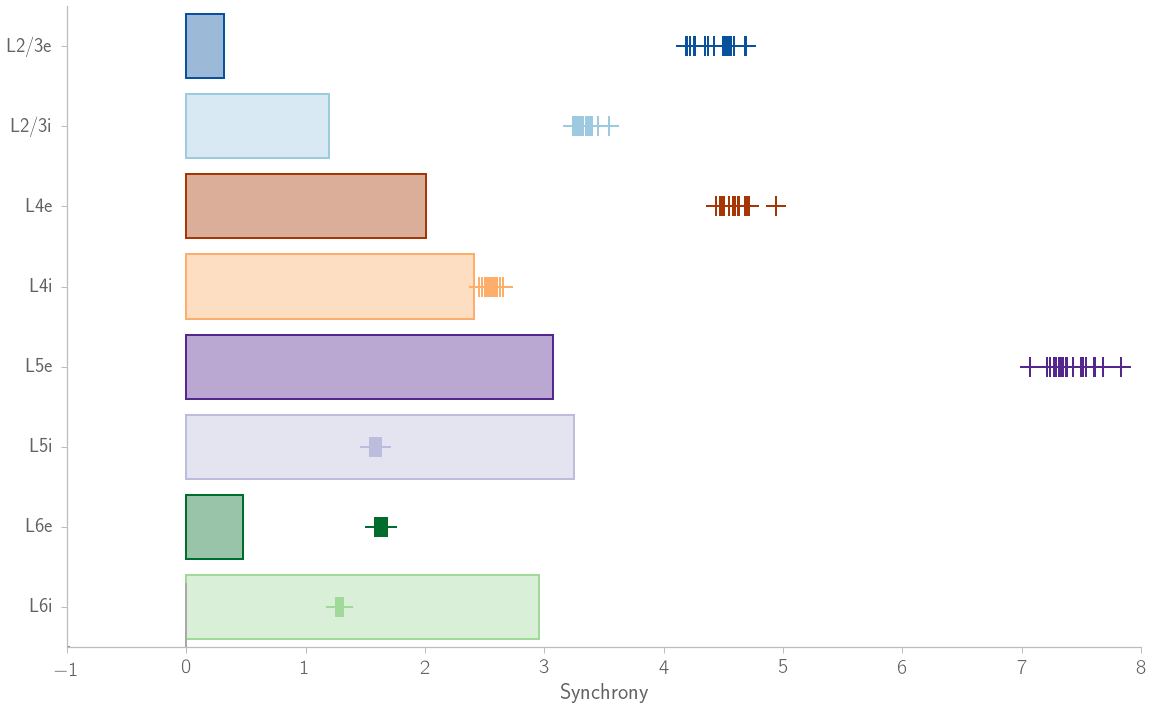

In [20]:

del_t = 3 * 1e-3 # s, time bin
synchrony_mf =  rate_mf * cv_isi_mf**2 / (1 + cv_isi_mf**2)

fig = plt.figure()

ax3 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(synchrony_all, synchrony_mf, ax3)
ax3.set_xlabel("Synchrony")

for ax in fig.axes:
    style.fixticks(ax)
    
synchrony_all[0], synchrony_mf, synchrony_all[0] / synchrony_mf

## With connection_rule = "fixed_indegree":

Integration time: 0.07
CV calc time: 0.53


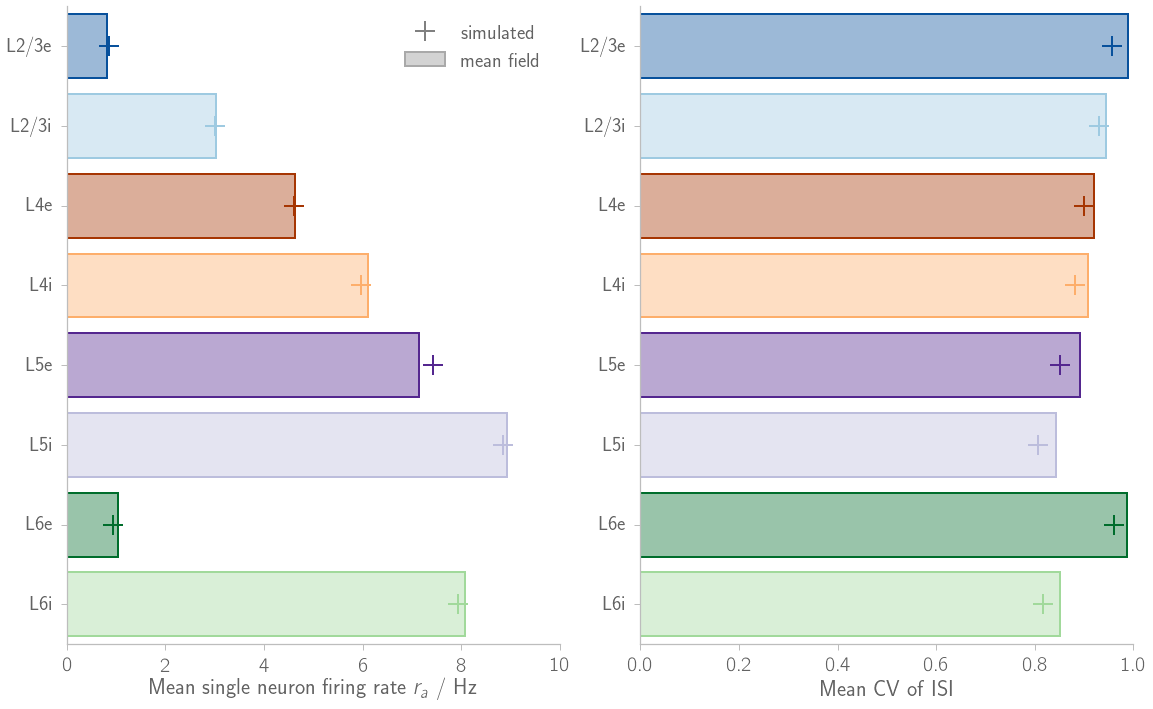

In [37]:
#sim_spec = "a1.0_t20.2_fixindeg_01"
sim_spec = "simulation_at_mf"
neuron_model    = "iaf_psc_delta"
connection_rule = "fixed_indegree"

######################################################
# Mean field results
######################################################

weight_rel_sd   = 0.1
model     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model, v_guess_0,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA

data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    cv_isi_mean_all     = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
data = cv_isi_mean_all
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_indegree"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

# Check $\mu$ and $\sigma$
### For consistency, and for the numerical stability of the algorithm applied...

In [10]:
mu_brunel = model_micro.mu(rate_mf[::-1])
sd_brunel = model_micro.sd(rate_mf[::-1])
mu_brunel, sd_brunel

(array([ 35.95056827,  41.19447994,   3.9172597 ,  20.65606839,
         50.05094192,  34.03839799,  40.74860721,  37.68801014]),
 array([ 5.8335019 ,  4.80950918,  5.48111228,  6.18623123,  4.504506  ,
         3.73627247,  3.47004715,  2.66128992]))

### Check numerics

For various intial conditions:
> Those measured in simulation

> Those from simulated transition

In [4]:
def check_solve(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root, fsolve
    # Instantiation
    if jacobian:
        jac = model.jacobian
    else:
        jac = False

    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    v0  = sol["x"]
    return v0, sol
        

In [127]:
weight_rel_sd   = 0.1
neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"

model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 


# Rates from transition
print("Rates from transition")
v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
for jacobian in [False, True]:
    print("Use jacobian:", jacobian)

    #jacobian=False
    root_method='hybr'
    options= {"xtol": 1e-13, "maxfev": 10**4}

    t_int0      = time.time()
    rate_mf, sol = check_solve(model_micro, v_guess_0,
                    jacobian=jacobian, root_method=root_method, options=options)
    t_int1      = time.time() - t_int0

    res_str = "\tt_int: %.2f\t nfev: %i\t success: "%(t_int1, sol["nfev"]) + str(sol["success"])
    print(res_str)
    
print("\nRates from simulation")
for jacobian in [False, True]:
    print("Use jacobian:", jacobian)
    n_success = 0
    n_sims = len(rates_mean_all)
    tints = np.zeros(n_sims)
    nfevs = np.zeros(n_sims) 
    for j in range(n_sims):
        v_guess_0       = rates_mean_all[j]
        
        #jacobian=False
        root_method='hybr'
        options= {"xtol": 1e-13, "maxfev": 10**4}

        t_int0      = time.time()
        rate_mf, sol = check_solve(model_micro, v_guess_0,
                        jacobian=jacobian, root_method=root_method, options=options)
        t_int1      = time.time() - t_int0
        
        res_str = "%i\tt_int: %.2f\t nfev: %i\t success: "%(j, t_int1, sol["nfev"]) + str(sol["success"])
        print(res_str)
        
        n_success += sol["success"]
        tints[j] = t_int1
        nfevs[j] = sol["nfev"]
        
    print(np.mean(tints), np.mean(nfevs))
    print("%i out of %i\n"%(n_success, n_sims))

Rates from transition
Use jacobian: False
	t_int: 0.14	 nfev: 46	 success: True
Use jacobian: True
	t_int: 0.22	 nfev: 79	 success: True

Rates from simulation
Use jacobian: False
0	t_int: 0.11	 nfev: 38	 success: True
1	t_int: 0.26	 nfev: 27	 success: False
2	t_int: 0.17	 nfev: 60	 success: True
3	t_int: 0.12	 nfev: 42	 success: True
4	t_int: 0.25	 nfev: 86	 success: True
5	t_int: 0.13	 nfev: 42	 success: True
6	t_int: 0.11	 nfev: 37	 success: True
7	t_int: 0.13	 nfev: 44	 success: True
8	t_int: 0.14	 nfev: 45	 success: True
9	t_int: 0.13	 nfev: 44	 success: True
10	t_int: 0.12	 nfev: 40	 success: True
11	t_int: 0.14	 nfev: 45	 success: True
12	t_int: 0.21	 nfev: 68	 success: True
13	t_int: 0.17	 nfev: 57	 success: True
14	t_int: 0.11	 nfev: 36	 success: True
15	t_int: 0.13	 nfev: 42	 success: True
16	t_int: 0.13	 nfev: 42	 success: True
17	t_int: 0.11	 nfev: 37	 success: True
18	t_int: 0.12	 nfev: 42	 success: True
19	t_int: 0.11	 nfev: 38	 success: True
0.144635474682 45.6
19 out of

### Compare solver for Brunel and Micro

In [7]:
# Unchanged parameters
area            = 1.0
neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
g               = 4.0
rate_ext        = 8.0 # Hz background rate
weight_rel_sd   = 0.1
delay_rel_sd    = 0.0

# Brunel:
j02             = 1.0
weight_rel_sd   = 0.0
n_neurons       = "brunel"
C_ab            = "brunel"
model_brunel      = model_class.model(area=area, 
                                      neuron_model=neuron_model,
                                       n_neurons=n_neurons, C_ab=C_ab, 
                                       connection_rule=connection_rule,
                                       j02=j02, g=g, rate_ext=rate_ext,
                                       weight_rel_sd=weight_rel_sd, 
                                       delay_rel_sd=delay_rel_sd) 


# Microcircuit light:
# only some parameters like Potjans" model
# adapt n_neurons AND C_ab!
j02             = 2.0
weight_rel_sd   = 0.1
n_neurons       = "micro"
C_ab            = "micro"
model_micro       = model_class.model(area=area, 
                                      neuron_model=neuron_model,
                                      n_neurons=n_neurons, C_ab=C_ab, 
                                      connection_rule=connection_rule,
                                      j02=j02, g=g, rate_ext=rate_ext,
                                      weight_rel_sd=weight_rel_sd, 
                                      delay_rel_sd=delay_rel_sd) 

model_names = ["Brunel", "Micro"]

n = model_micro.n_populations # Dimension
r_max_total = 1.0       # Radius around which solutions are sampled

root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**4}
jacobian = False

n_rs = 10 + 1
n_sims = 1

r_max_all = np.linspace(0, r_max_total, n_rs)
tints_mean = np.zeros((2, n_rs))
nfevs_mean = np.zeros((2, n_rs))
success_rate = np.zeros((2, n_rs))

for k, model in enumerate([model_micro, model_brunel]):
    print(model_names[k])
    v_sol = solve_model(model)
    print("r_max\tsuccess_rate\tt_int/s\tn_fevs")
    for j, r_max in enumerate(r_max_all[1:]):
        n_success = 0
        tints = np.zeros(n_rs)
        nfevs = np.zeros(n_rs) 
        for i in range(n_sims):
            # Sample initial conditions        
            x = np.random.normal(0, 1, n)
            r = np.random.uniform(r_max_all[j-1], r_max_all[j])
            offset = r**(1 / n) / np.linalg.norm(x) * x
            v_guess_0 = v_sol + offset   

            t_int0      = time.time()
            rate_mf, sol = check_solve(model, v_guess_0,
                            jacobian=jacobian, root_method=root_method, options=options)
            t_int1      = time.time() - t_int0

            n_success += sol["success"]
            tints[i] = t_int1
            nfevs[i] = sol["nfev"]

        tints_mean[k, j] = np.mean(tints)
        nfevs_mean[k, j] = np.mean(nfevs)
        success_rate[k, j] = float(n_success) / float(n_sims)
        res_str = "{0:6.2f}\t\t{1:6.2f}\t{2:6.2f}\t{3:6.2f}".format(
            r_max, success_rate[k, j], tints_mean[k, j], nfevs_mean[k, j])
        print(res_str)

        
print("done")
data_path        = "/users/schuessler/uni/microcircuit/analysis"
res_file_name   = "check_numerics.hdf5"
path_res_file   = os.path.join(data_path, res_file_name)
with h5py.File(path_res_file, "w") as  res_file:
    res_file.create_dataset("r_max_all", data=r_max_all[1:])
    res_file.create_dataset("tints_mean", data=tints_mean)
    res_file.create_dataset("nfevs_mean", data=nfevs_mean)
    res_file.create_dataset("success_rate", data=success_rate)

Brunel
r_max	success_rate	t_int/s	n_fevs
  0.00		  1.00	  0.01	  2.18
  0.10		  1.00	  0.01	  1.82
  0.20		  1.00	  0.01	  2.18
  0.30		  1.00	  0.01	  2.45
  0.40		  1.00	  0.01	  3.36
  0.50		  1.00	  0.01	  2.45
  0.60		  1.00	  0.01	  3.18
  0.70		  1.00	  0.01	  2.82
  0.80		  1.00	  0.02	  6.64

/usr/local/lib/python3.4/dist-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.4/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)



  0.90		  0.00	  0.07	 18.18
  1.00		  1.00	  0.01	  5.55
Micro
r_max	success_rate	t_int/s	n_fevs
  0.00		  1.00	  0.02	  5.27
  0.10		  1.00	  0.01	  4.00
  0.20		  1.00	  0.02	  4.91
  0.30		  1.00	  0.01	  2.91
  0.40		  1.00	  0.02	  5.36
  0.50		  1.00	  0.02	  6.00
  0.60		  1.00	  0.02	  4.73
  0.70		  0.00	  0.01	  2.91
  0.80		  1.00	  0.02	  5.73
  0.90		  1.00	  0.02	  4.73
  1.00		  1.00	  0.02	  5.55
done


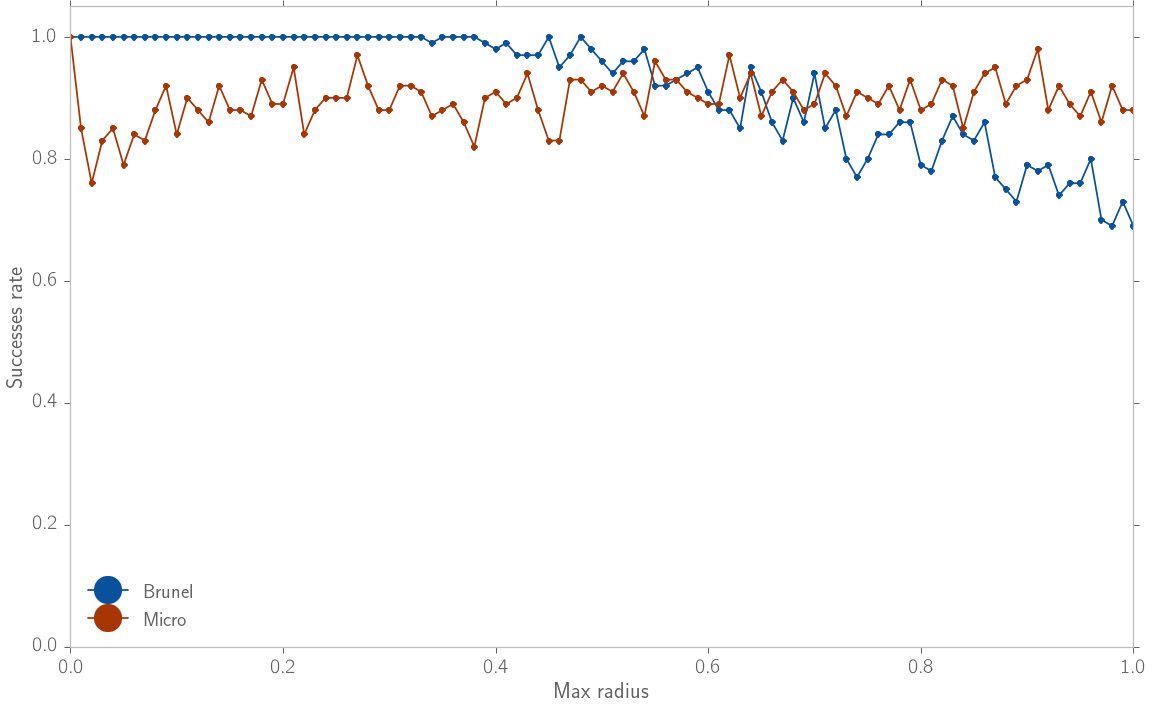

In [21]:
# Microcircuit light:
# only some parameters like Potjans" model
# adapt n_neurons AND C_ab!
j02             = 2.0
weight_rel_sd   = 0.1
n_neurons       = "micro"
C_ab            = "micro"
model_micro       = model_class.model() 
model_names = ["Brunel", "Micro"]

data_path        = "/users/schuessler/uni/microcircuit/analysis"
res_file_name   = "check_numerics.hdf5"
path_res_file   = os.path.join(data_path, res_file_name)
with h5py.File(path_res_file, "r") as  res_file:
    r_max_all     = res_file["r_max_all"][:]
    tints_mean    = res_file["tints_mean"][:]
    nfevs_mean    = res_file["nfevs_mean"][:]
    success_rate  = res_file["success_rate"][:]
    
fig = plt.figure()

ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
for k, model_name in enumerate(model_names):
    ax.plot(r_max_all, success_rate[k], '-o', color=colors[k*2], label=model_name)
    
ax.set_xlim(0, r_max_all[-1])
ax.set_xlabel("Max radius")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Successes rate")
ax.grid(False)
ax.legend(loc="best")


## Test dependency on $\Delta J$

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

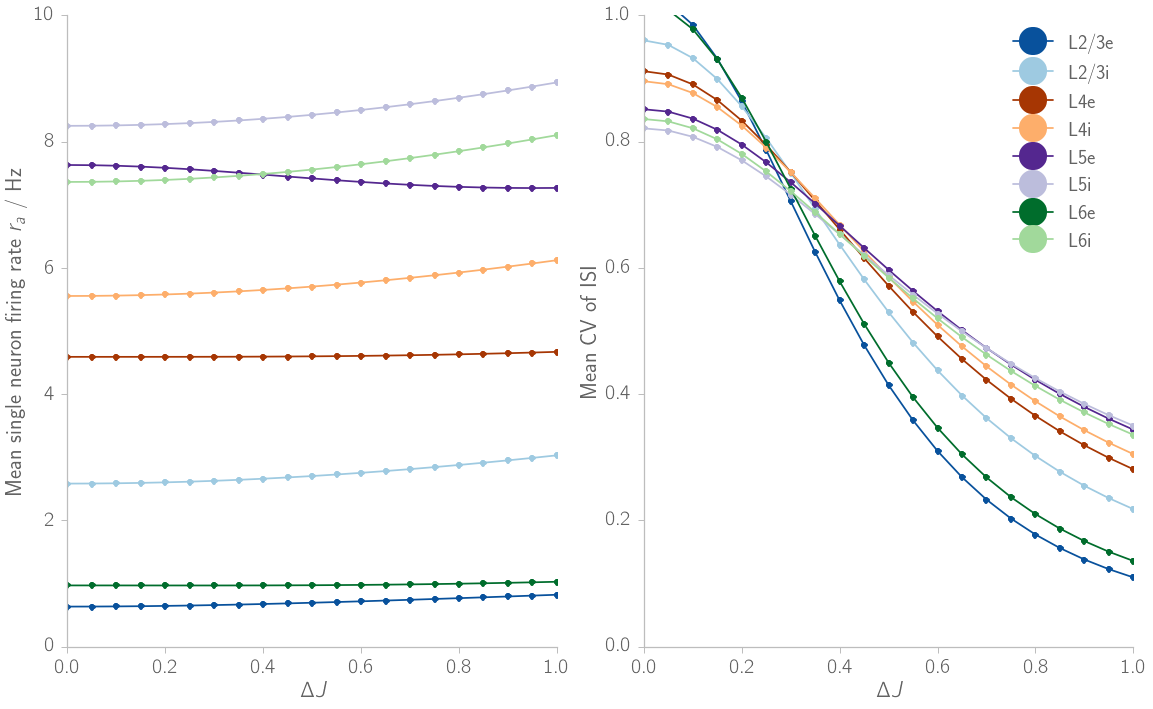

In [85]:
# Data
sim_spec = "a1.0_t20.4_00"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

n = 21
weight_rel_sds   = np.linspace(0, 1.0, n)
rates       = np.zeros((n, n_populations))
cv_isis     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"


v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for j, weight_rel_sd in enumerate(weight_rel_sds):
    print(j, end=" ")

    model_micro     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        weight_rel_sd=weight_rel_sd) 
    t_int0      = time.time()
    rates[j]     = solve_model(model_micro, v_guess_0,
                              root_method=root_method, options=options)
    t_int1      = time.time() - t_int0
    #print("Integration time: %.2f"%(t_int1))

    t_int0      = time.time()
    cv_isis[j]   = CV_ISI_mf(rate_mf, model=model_micro)
    t_int1      = time.time() - t_int0
    #print("CV calc time: %.2f"%(t_int1))


fig = plt.figure()

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(populations):
    ax1.plot(weight_rel_sds, rates[:, i], '-o', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(weight_rel_sds, cv_isis[:, i], '-o', color=colors[i],
        label=hf.rlbl(population))
    

ax1.set_ylabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_ylim(0, 10)

ax2.set_ylabel("Mean CV of ISI")
ax2.set_ylim(0, 1)
ax2.legend(loc="best")

for ax in fig.axes:
    ax.set_xlabel("$\Delta J$")
    style.fixticks(ax)